# IRAC forced photometry using tractor
### following Kristina Nylands script

modified notebook for speedup

In [1]:
import math
import time
import warnings
import concurrent.futures

import sys
import os
from contextlib import contextmanager

import numpy as np

try:
    import pandas as pd
except ImportError:
    !{sys.executable} -m pip install -U pandas

import pandas as pd

import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    !{sys.executable} -m pip install -U seaborn
    
import seaborn as sns

try: 
    import statsmodels
except ImportError:
    !{sys.executable} -m pip install -U statsmodels
import statsmodels

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
import astropy.wcs as wcs
import astropy.io.fits as fits
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u

Irsa.ROW_LIMIT = 1E6



#try:
#    from reproject import reproject_interp
#except ImportError:
#    !{sys.executable} -m pip install -U reproject

#from reproject import reproject_interp

from skimage.transform import rotate

from tractor import (Tractor, PointSource, PixPos, Flux, PixelizedPSF, NullWCS,
                     NullPhotoCal, ConstantSky, Image)


sys.path.append('/home/jkrick/fornax-demo-notebooks/code/')
from determine_source_type import determine_source_type
from extract_cutout import extract_cutout
from find_nconfsources import find_nconfsources
from display_images import display_images
from plot_SED import plot_SED
#from prepare_prf import prepare_prf

set up clean catalog with fiducial band fluxes, ra, dec, shape parameters, probability that it is a star

In [2]:
#pull a COSMOS catalog from IRSA using astroquery
coords = SkyCoord('10h00m28.6s +02d12m21.0s', frame='icrs')  #COSMOS center acording to Simbad
cosmos_table = Irsa.query_region(coords, catalog = "cosmos2015",  radius = 3*u.arcmin,selcols='ra,dec,id,Ks_FLUX_APER2,Ks_FLUXERR_APER2, SPLASH_1_FLUX, SPLASH_1_FLUX_ERR,SPLASH_2_FLUX, SPLASH_2_FLUX_ERR,SPLASH_3_FLUX, SPLASH_3_FLUX_ERR,SPLASH_4_FLUX, SPLASH_4_FLUX_ERR, FLUX_GALEX_NUV,FLUX_GALEX_FUV,FLUX_CHANDRA_05_2,FLUX_CHANDRA_2_10, FLUX_CHANDRA_05_10,ID_CHANDRA09 , type ')

#select those rows with either chandra fluxes or Galex NUV fluxes
ccosmos_table = cosmos_table[(cosmos_table['flux_chandra_05_10']> 0) | (cosmos_table['flux_galex_fuv'] > 0)]
ccosmos_table

#convert to pandas
df = ccosmos_table.to_pandas()

# set default cutout width = 10"
cutout_width = 10



In [3]:
#are there missing values
df.isna().sum()

#don't mind that there are missing values for IRAC flues or for photzs.  
#The rest of the rows are complete

ra                      0
dec                     0
clon                    0
clat                    0
id                      0
ks_flux_aper2           0
ks_fluxerr_aper2        0
splash_1_flux           0
splash_1_flux_err       0
splash_2_flux           1
splash_2_flux_err       1
splash_3_flux          13
splash_3_flux_err      13
splash_4_flux           1
splash_4_flux_err       1
flux_galex_nuv         90
flux_galex_fuv         17
flux_chandra_05_2     405
flux_chandra_2_10     405
flux_chandra_05_10    405
id_chandra09          405
type                    0
dist                    0
angle                   0
dtype: int64

In [4]:
#ot of curiosity how many stars vs. galaxies vs. x ray sources
df.type.value_counts()

0    396
2     21
1      9
Name: type, dtype: int64

In [5]:
# initialize columns in data frame for photometry results
df[["ch1flux","ch1flux_unc","ch2flux","ch2flux_unc","ch3flux","ch3flux_unc","ch4flux","ch4flux_unc"]] = 0.0
df

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,150.118493,2.205771,10h00m28.44s,02d12m20.77s,595469,1.056,0.096,0.722,0.025,0.492,...,2.445971,264.982454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150.116738,2.207050,10h00m28.02s,02d12m25.38s,598571,3.401,0.096,9.608,0.449,7.234,...,9.787274,296.656327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150.115847,2.206479,10h00m27.80s,02d12m23.32s,595479,5.422,0.059,4.627,0.021,4.105,...,12.179616,281.051673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150.120755,2.202604,10h00m28.98s,02d12m09.38s,593339,1.761,0.097,1.013,0.033,0.888,...,12.936966,153.843126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,150.114737,2.207214,10h00m27.54s,02d12m25.97s,596351,1.069,0.096,1.624,0.051,1.819,...,16.707869,287.349145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,150.112516,2.255071,10h00m27.00s,02d15m18.25s,629311,1.745,0.089,3.123,0.035,3.634,...,178.875611,352.310129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
422,150.070442,2.216165,10h00m16.91s,02d12m58.19s,603113,4.376,0.098,1.950,0.059,NaN,...,179.195281,281.983930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
423,150.138095,2.159699,10h00m33.14s,02d09m34.92s,565081,3.517,0.092,3.242,0.072,2.562,...,179.484631,157.708565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
424,150.108728,2.157015,10h00m26.09s,02d09m25.25s,564716,7.170,0.094,22.916,0.477,27.307,...,179.704075,192.065342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#setup to supress output of tractor
#seems to be the only way to make it be quiet and not output every step of optimization
#https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [7]:
# parameters needed for the next function
    
irac_fluxconversion = (1E12) / (4.254517E10) * (0.6) *(0.6) #convert tractor result to microjanskies
flux_conv = irac_fluxconversion
mosaic_pix_scale = 0.6
    
#set up prfs for each channel
prfs = [fits.open('../data/PRF_IRAC_ch1.fits')[0].data,
        fits.open('../data/PRF_IRAC_ch2.fits')[0].data,
        fits.open('../data/PRF_IRAC_ch3.fits')[0].data,
        fits.open('../data/PRF_IRAC_ch4.fits')[0].data]
    
#set up mosaics for each channel
infiles = ['../data/COSMOS_irac_ch1_mosaic_recenter.fits',
           '../data/COSMOS_irac_ch2_mosaic_recenter.fits',
           '../data/COSMOS_irac_ch3_mosaic_recenter.fits',
           '../data/COSMOS_irac_ch4_mosaic_recenter.fits']

#read in those mosaics only once here instead of inside the function
hdulists = [fits.open(infiles[0])[0], fits.open(infiles[1])[0],fits.open(infiles[2])[0],fits.open(infiles[3])[0]]
headers = [hdulists[0].header,hdulists[1].header,hdulists[2].header,hdulists[3].header]

#grab the WCS of the mosaics
wcs_infos = [wcs.WCS(hdulists[0]),wcs.WCS(hdulists[1]),wcs.WCS(hdulists[2]),wcs.WCS(hdulists[3])]


In [8]:
def calc_instrflux(band, ra, dec, stype, ks_flux_aper2):
    """
    calculate instrumental fluxes and uncertainties for four IRAC bands 
    
    Parameters:
    -----------
    band: int
        integer in [0, 1, 2, 3] for the four IRAC bands
    ra, dec: float or double
        celestial coordinates for measuring photometry
    stype: int
        0, 1, 2 for star, galaxy, x-ray source
    ks_flux_aper_2: float
        flux in aperture 2
        
    Returns:
    --------
    outband: int
        reflects input band for identification purposes
    flux: float
        measured flux in microJansky, NaN if unmeasurable
    unc: float
        measured uncertainty in microJansky, NaN if not able to estimate
    """
    prf = prfs[band]
    infile = infiles[band]
    hdr = headers[band]
    
    #make a cutout
    subimage, nodata_param, x1, y1, subimage_wcs = extract_cutout(ra, dec,cutout_width, mosaic_pix_scale, hdulists[band], wcs_infos[band])
    
    #catch errors in making the cutouts
    if nodata_param == False:  #meaning we have data in the cutout
        
        #set up the source list
        #src = determine_source_type(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1)
        objsrc, nconfsrcs = find_nconfsources(ra, dec, stype,
                        ks_flux_aper2, x1,y1, cutout_width, subimage_wcs, df)

        #measure sky noise and mean level
        skymean, skymedian, skynoise = sigma_clipped_stats(subimage, sigma=3.0)
        
        #make the tractor image
        tim=Image(data=subimage, invvar=np.ones_like(subimage) / skynoise**2, 
              psf=PixelizedPSF(prf) ,
              wcs=NullWCS(),photocal=NullPhotoCal(),sky=ConstantSky(skymean))
               
        # make tractor object
        tractor=Tractor([tim], objsrc) #[src]

        #freeze the parameters we don't want tractor fitting
        tractor.freezeParam('images') #now fits 2 positions and flux
        #only fit for flux
        #src.freezeAllRecursive()
        #src.thawPathsTo('brightness')


        #run the tractor optimization (do forced photometry)
        # Take several linearized least squares steps
        fit_fail = False
        try:
            tr = 0
            with suppress_stdout():
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', '.*divide by zero.*')
                    #warnings.simplefilter('ignore')
                    for tr in range(20):
                        dlnp,X,alpha, flux_var=tractor.optimize(variance = True)
                        #print('dlnp',dlnp)
                        if dlnp < 1e-3:
                            break
        # catch exceptions and bad fits
        except:
            fit_fail = True
            
        # record the photometry results
        if fit_fail: 
            #tractor fit failed
            #set flux and uncertainty as nan and move on
            return(band, np.nan, np.nan)
        elif flux_var is None:  
            #fit worked, but flux variance did not get reported
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
             #convert to microjanskies
            microJy_flux = flux * flux_conv
            return(band, microJy_flux, np.nan)
        else: 
            #fit and variance worked
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
                
            # determine flux uncertainty
            #which value of flux_var is for the flux variance?
            fv = ((nconfsrcs+1)*3) - 1  #assumes we are fitting positions and flux
            tractor_std = np.sqrt(flux_var[fv])  
                
            #convert to microjanskies
            microJy_flux = flux * flux_conv
            microJy_unc = tractor_std *flux_conv
            return(band, microJy_flux, microJy_unc)
        
    else:
        return(band, np.nan, np.nan)


Make a copy of the dataframe for the parallel calculation.

In [9]:
pl_df = df.copy(deep=True)

Run it on everything

In [10]:
%%time
t0 = time.time()
for row in df.itertuples():
    for band in range(4):
        outband, flux, unc = calc_instrflux(band, row.ra, row.dec, row.type, row.ks_flux_aper2)
        df.loc[row.Index, 'ch{:d}flux'.format(outband+1)] = flux
        df.loc[row.Index, 'ch{:d}flux_unc'.format(outband+1)] = unc
        #print(row.ra, row.dec, row.type, row.ks_flux_aper2, band+1,
        #      outband, flux, unc)
t1 = time.time()

CPU times: user 1min 9s, sys: 63.2 ms, total: 1min 9s
Wall time: 1min 9s


Parallelization: we can either interate over the rows of the dataframe and run the four bands in parallel; or we could zip together the row index, band, ra, dec, 

In [11]:
paramlist = []
for row in df.itertuples():
    for band in range(4):
        paramlist.append([row.Index, band, row.ra, row.dec, row.type, row.ks_flux_aper2])

In [12]:
print(len(paramlist))

1704


In [13]:
calc_instrflux(paramlist[0][1], paramlist[0][2], paramlist[0][3], paramlist[0][4], paramlist[0][5])

(0, 0.36444629075507395, 1.0180128707832645)

In [14]:
calc_instrflux(*paramlist[0][1:])

(0, 0.36444629075507395, 1.0180128707832645)

In [15]:
def calculate_flux(args):
    """Calculate flux."""
    f = calc_instrflux
    val = f(*args[1:])
    return(args[0], val)

In [16]:
%%time
t2 = time.time()
outputs = []
with concurrent.futures.ProcessPoolExecutor(24) as executor:
    for result in executor.map(calculate_flux, paramlist):
        # print(result)
        pl_df.loc[result[0],
                  'ch{:d}flux'.format(result[1][0] + 1)] = result[1][1]
        pl_df.loc[result[0],
                  'ch{:d}flux_unc'.format(result[1][0] + 1)] = result[1][1]
        outputs.append(result)
t3 = time.time()

CPU times: user 2.68 s, sys: 878 ms, total: 3.56 s
Wall time: 6.98 s


In [17]:
print('Serial calculation took {:.2f} seconds'.format((t1 - t0)))
print('Parallel calculation took {:.2f} seconds'.format((t3 - t2)))
print('Speedup is {:.2f}'.format((t1 - t0) / (t3 - t2)))

Serial calculation took 69.54 seconds
Parallel calculation took 6.98 seconds
Speedup is 9.96


Count the number of non-zero ch1 fluxes

In [18]:
print('Serial calculation: number of ch1 fluxes filled in =',
      np.sum(df.ch1flux > 0))
print('Parallel calculation: number of ch1 fluxes filled in =',
      np.sum(pl_df.ch1flux > 0))

Serial calculation: number of ch1 fluxes filled in = 138
Parallel calculation: number of ch1 fluxes filled in = 138


Continue with the rest of the notebook using the populated dataframe

In [19]:
#just checking that df is getting filled in properly
#rows with zero fluxes are likely outside the bounds of the mosaic
df

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,150.118493,2.205771,10h00m28.44s,02d12m20.77s,595469,1.056,0.096,0.722,0.025,0.492,...,2.445971,264.982454,0.364446,1.018013,0.220715,3.757389,1.948099,0.998862,5.288253,7.103445
1,150.116738,2.207050,10h00m28.02s,02d12m25.38s,598571,3.401,0.096,9.608,0.449,7.234,...,9.787274,296.656327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150.115847,2.206479,10h00m27.80s,02d12m23.32s,595479,5.422,0.059,4.627,0.021,4.105,...,12.179616,281.051673,7.429757,0.229637,8.805782,0.301511,NaN,NaN,15.704786,1.935709
3,150.120755,2.202604,10h00m28.98s,02d12m09.38s,593339,1.761,0.097,1.013,0.033,0.888,...,12.936966,153.843126,0.878860,0.111339,1.004434,0.258956,4.959029,1.177379,-8.257976,2.089586
4,150.114737,2.207214,10h00m27.54s,02d12m25.97s,596351,1.069,0.096,1.624,0.051,1.819,...,16.707869,287.349145,0.803511,0.134956,1.973373,0.212424,NaN,NaN,-14.066155,2.289420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,150.112516,2.255071,10h00m27.00s,02d15m18.25s,629311,1.745,0.089,3.123,0.035,3.634,...,178.875611,352.310129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,150.070442,2.216165,10h00m16.91s,02d12m58.19s,603113,4.376,0.098,1.950,0.059,NaN,...,179.195281,281.983930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,150.138095,2.159699,10h00m33.14s,02d09m34.92s,565081,3.517,0.092,3.242,0.072,2.562,...,179.484631,157.708565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,150.108728,2.157015,10h00m26.09s,02d09m25.25s,564716,7.170,0.094,22.916,0.477,27.307,...,179.704075,192.065342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#how many rows did get filled in?  = 225
df_fill = df[df.ch1flux > 0]
df_fill

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,150.118493,2.205771,10h00m28.44s,02d12m20.77s,595469,1.056,0.096,0.722,0.025,0.492,...,2.445971,264.982454,0.364446,1.018013,0.220715,3.757389,1.948099,0.998862,5.288253,7.103445
2,150.115847,2.206479,10h00m27.80s,02d12m23.32s,595479,5.422,0.059,4.627,0.021,4.105,...,12.179616,281.051673,7.429757,0.229637,8.805782,0.301511,NaN,NaN,15.704786,1.935709
3,150.120755,2.202604,10h00m28.98s,02d12m09.38s,593339,1.761,0.097,1.013,0.033,0.888,...,12.936966,153.843126,0.878860,0.111339,1.004434,0.258956,4.959029,1.177379,-8.257976,2.089586
4,150.114737,2.207214,10h00m27.54s,02d12m25.97s,596351,1.069,0.096,1.624,0.051,1.819,...,16.707869,287.349145,0.803511,0.134956,1.973373,0.212424,NaN,NaN,-14.066155,2.289420
5,150.114557,2.203116,10h00m27.49s,02d12m11.22s,593912,8.325,0.096,10.811,0.077,9.551,...,19.257384,239.511648,46.697130,0.413576,31.604323,0.413498,28.772049,1.310927,18.178550,2.054411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,150.101081,2.179571,10h00m24.26s,02d10m46.46s,578594,4.987,0.092,5.093,0.058,3.893,...,114.762024,214.542429,4.601350,0.258883,4.596522,1.554016,-107.282263,1.414244,194.235989,4.404920
205,150.141363,2.180989,10h00m33.93s,02d10m51.56s,578961,1.437,0.092,0.847,0.028,0.822,...,119.879955,138.243590,1.025075,0.130781,-0.813545,0.193575,6.938891,1.502571,64.145149,40.846001
210,150.095893,2.230237,10h00m23.01s,02d13m48.85s,612914,5.143,0.097,2.801,0.057,1.771,...,121.375913,316.379784,2.953218,0.757765,1.914025,0.734985,-4.865795,7.073445,-9.088799,6.792147
213,150.144376,2.228839,10h00m34.65s,02d13m43.82s,611348,1.081,0.096,0.552,0.030,0.288,...,122.811869,47.587051,0.273177,0.098818,-0.456867,0.189107,1.240715,1.143224,-10.581008,4.559377


In [21]:
#how many rows did get filled in?  = 225
pl_df_fill = pl_df[pl_df.ch1flux > 0]
pl_df_fill

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,dist,angle,ch1flux,ch1flux_unc,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc
0,150.118493,2.205771,10h00m28.44s,02d12m20.77s,595469,1.056,0.096,0.722,0.025,0.492,...,2.445971,264.982454,0.364446,0.364446,0.220715,0.220715,1.948099,1.948099,5.288253,5.288253
2,150.115847,2.206479,10h00m27.80s,02d12m23.32s,595479,5.422,0.059,4.627,0.021,4.105,...,12.179616,281.051673,7.429757,7.429757,8.805782,8.805782,NaN,NaN,15.704786,15.704786
3,150.120755,2.202604,10h00m28.98s,02d12m09.38s,593339,1.761,0.097,1.013,0.033,0.888,...,12.936966,153.843126,0.878860,0.878860,1.004434,1.004434,4.959029,4.959029,-8.257976,-8.257976
4,150.114737,2.207214,10h00m27.54s,02d12m25.97s,596351,1.069,0.096,1.624,0.051,1.819,...,16.707869,287.349145,0.803511,0.803511,1.973373,1.973373,NaN,NaN,-14.066155,-14.066155
5,150.114557,2.203116,10h00m27.49s,02d12m11.22s,593912,8.325,0.096,10.811,0.077,9.551,...,19.257384,239.511648,46.697130,46.697130,31.604323,31.604323,28.772049,28.772049,18.178550,18.178550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,150.101081,2.179571,10h00m24.26s,02d10m46.46s,578594,4.987,0.092,5.093,0.058,3.893,...,114.762024,214.542429,4.601350,4.601350,4.596522,4.596522,-107.282263,-107.282263,194.235989,194.235989
205,150.141363,2.180989,10h00m33.93s,02d10m51.56s,578961,1.437,0.092,0.847,0.028,0.822,...,119.879955,138.243590,1.025075,1.025075,-0.813545,-0.813545,6.938891,6.938891,64.145149,64.145149
210,150.095893,2.230237,10h00m23.01s,02d13m48.85s,612914,5.143,0.097,2.801,0.057,1.771,...,121.375913,316.379784,2.953218,2.953218,1.914025,1.914025,-4.865795,-4.865795,-9.088799,-9.088799
213,150.144376,2.228839,10h00m34.65s,02d13m43.82s,611348,1.081,0.096,0.552,0.030,0.288,...,122.811869,47.587051,0.273177,0.273177,-0.456867,-0.456867,1.240715,1.240715,-10.581008,-10.581008


CPU times: user 50.9 s, sys: 1.92 s, total: 52.9 s
Wall time: 50.4 s


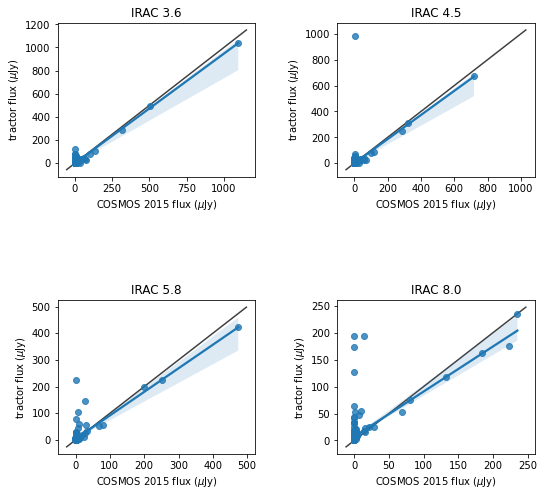

In [22]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#and hope I see a straightline with a slope of 1
#using sns regplot which plots both the data and a linear regression model fit
#this plotting tool is for visualization and not statistics, so I don't have rigorous slopes from it.
#need to still add uncertainties to the plotting and regression


#setup to plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch1flux> 0) & (df.ch1flux < 2000)]
sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 3.6')


#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch2flux> 0) & (df.ch2flux < 2000)]
sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 4.5')


#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch3flux> 0) & (df.ch3flux < 2000)]

sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 5.8')


#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.ch4flux> 0) & (df.ch4flux < 2000)]

sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax4.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 8.0')

plt.tight_layout()


fig.set_size_inches(8, 8)

#plt.savefig('flux_comparison_IRAC.png')

#### Tractor is working; Comparison of tractor derived fluxes with COSMOS 2015 fluxes for all four Spitzer IRAC channels.  Blue points represent each of ~250 randomly chosen objects from the COSMOS 2015 catalog.  The blue line is a linear regression robust fit to the data with uncertainties shown as the light blue wedge.  The black line is a y = x line plotted to guide the eye.